In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt  

In [2]:
train_path = './archive/train.txt'
val_path = './archive/val.txt'
test_path = './archive/test.txt'

train_df = pd.read_csv(train_path, sep=';', names=['Text', 'Emotion'])
val_df = pd.read_csv(val_path, sep=';', names=['Text', 'Emotion'])
test_df = pd.read_csv(test_path, sep=';', names=['Text', 'Emotion'])

train_df = train_df.drop(train_df[(train_df['Emotion'] == 'surprise') | (train_df['Emotion'] == 'love')].index)
val_df = val_df.drop(val_df[(val_df['Emotion'] == 'surprise') | (val_df['Emotion'] == 'love')].index)
test_df = test_df.drop(test_df[(test_df['Emotion'] == 'surprise') | (test_df['Emotion'] == 'love')].index)


In [3]:
label_encoder = LabelEncoder()
train_label = label_encoder.fit_transform(train_df['Emotion'])
val_label = label_encoder.transform(val_df['Emotion'])
test_label = label_encoder.transform(test_df['Emotion'])

d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\envs\lab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [4]:
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(train_df['Text'])

train_sequences = tokenizer.texts_to_sequences(train_df['Text'])
val_sequences = tokenizer.texts_to_sequences(val_df['Text'])
test_sequences = tokenizer.texts_to_sequences(test_df['Text'])

max_sequence_length = 200
train_feature = pad_sequences(train_sequences, maxlen=max_sequence_length, truncating='pre')
val_feature = pad_sequences(val_sequences, maxlen=max_sequence_length, truncating='pre')
test_feature = pad_sequences(test_sequences, maxlen=max_sequence_length, truncating='pre')

In [17]:
vocabSize = len(tokenizer.index_word) + 1
vocabSize

14081

In [16]:
maxlen = max([len(t) for t in train_df['Text']])
maxlen

300

In [5]:
class TextDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        features = self.features[idx]
        labels = self.labels[idx]
        features = torch.tensor(features, dtype=torch.long)
        labels = torch.tensor(labels, dtype=torch.long)
        return features, labels

train_dataset = TextDataset(train_feature, train_label)
val_dataset = TextDataset(val_feature, val_label)
test_dataset = TextDataset(test_feature, test_label)

train_loader = DataLoader(train_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x[:, -1, :])
        x = self.relu(x)
        x = self.fc(x)
        return x

vocab_size = 10000 + 1 
embedding_dim = 200
hidden_dim = 256
output_dim = len(label_encoder.classes_)

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

d:\anaconda3\envs\lab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 50
train_losses = []
val_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0

    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        
        predictions = torch.argmax(outputs, dim=1)
        correct_train_predictions += torch.sum(predictions == labels)
        
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_predictions.double() / len(train_loader.dataset)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
            predictions = torch.argmax(outputs, dim=1)
            correct_val_predictions += torch.sum(predictions == labels)

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val_predictions.double() / len(val_loader.dataset)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1/50, Training Loss: 0.1325, Training Accuracy: 0.9538, Validation Loss: 0.1987, Validation Accuracy: 0.9299
Epoch 2/50, Training Loss: 0.0663, Training Accuracy: 0.9764, Validation Loss: 0.1791, Validation Accuracy: 0.9449
Epoch 3/50, Training Loss: 0.0389, Training Accuracy: 0.9861, Validation Loss: 0.2022, Validation Accuracy: 0.9426
Epoch 4/50, Training Loss: 0.0412, Training Accuracy: 0.9874, Validation Loss: 0.1908, Validation Accuracy: 0.9449
Epoch 5/50, Training Loss: 0.0257, Training Accuracy: 0.9924, Validation Loss: 0.2064, Validation Accuracy: 0.9449
Epoch 6/50, Training Loss: 0.0128, Training Accuracy: 0.9959, Validation Loss: 0.2080, Validation Accuracy: 0.9437
Epoch 7/50, Training Loss: 0.0330, Training Accuracy: 0.9882, Validation Loss: 0.2246, Validation Accuracy: 0.9431
Epoch 8/50, Training Loss: 0.0166, Training Accuracy: 0.9950, Validation Loss: 0.2313, Validation Accuracy: 0.9449
Epoch 9/50, Training Loss: 0.0123, Training Accuracy: 0.9961, Validation Loss: 0

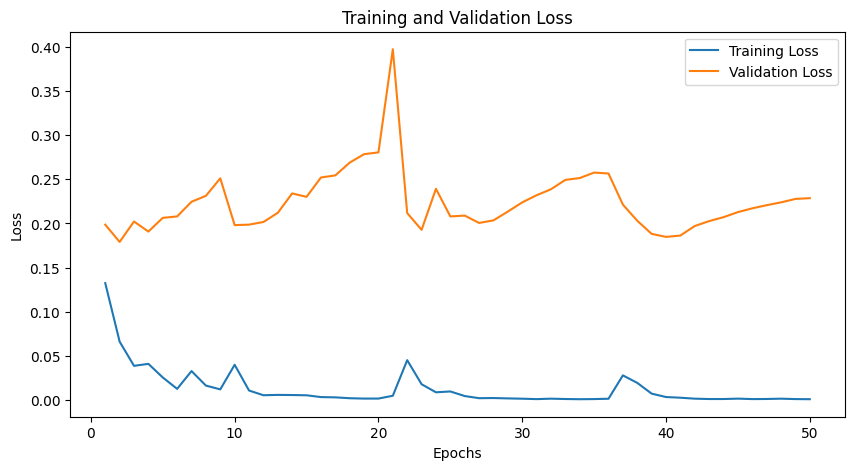

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
model.eval()
total_test_loss = 0
correct_predictions = 0
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        correct_predictions += torch.sum(predictions == labels)

avg_test_loss = total_test_loss / len(test_loader)
accuracy = correct_predictions.double() / len(test_loader.dataset)

print(f'Test Loss: {avg_test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Test Loss: 0.2466
Test Accuracy: 0.9606


In [11]:
torch.save(model.state_dict(), './Model_B.pth')